<blockquote>
This is a lecture notebook that we have used for past boot camps, but did not use this year.
    
Here we cover an alternative approach to regression for situations where your random errors do note have equal variance.
</blockquote>


# Weighted Linear Regression

We will end our regression lectures by introducing weighted linear regression, a regression approach that helps address when your residuals <i>do not</i> appear to have equal variances.

## What we will accomplish

In this notebook we will:
- Discuss the idea behind weighted least squares
- Demonstrate how to fit a weighted least squares model in `sklearn`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import set_style

set_style("darkgrid")

## The idea

I am once again asking you to remember our regression model:

$$
y = X \beta + \epsilon, \text{ where we assume } \epsilon \sim N(0,\sigma) \text{ are independent of } X.
$$

Remember that we found the ordinary least squares (OLS) estimate for this model by minimizing the mean square error (MSE):

$$
\text{MSE}(\beta) = \frac{1}{n} \sum_{i=1}^n \left( y^{(i)} - X^{(i)}\beta \right)^2.
$$

Another approach for producing an estimate for the regression line is by minimizing a weighted MSE (WMSE) for a set of chosen weights, $w^{(i)}$:

$$
\text{WMSE}(\beta, w^{(1)}, \dots, w^{(n)}) = \frac{1}{n} \sum_{i=1}^n w^{(i)} \left( y^{(i)} - X^{(i)}\beta \right)^2
$$

$$
= \frac{1}{n} \left( y - X\beta \right)^T W \left( y - X\beta \right) = \frac{1}{n} \left( y^TWy -y^TWX\beta - \beta^TX^TWy + \beta^T X^T W X \beta \right),
$$

where $W$ is a diagonal matrix with $w^{(i)}$ along the diagonal.

Taking the matrix of WMSE with respect to $\beta$ and setting it equal to $0$ gives the following weighted least squares estimate for $\beta$:

$$
\hat{\beta}_{\text{WLS}} = \left( X^TWX \right)^{-1}X^TWy.
$$

### Why perform weighted regression?

Weighted regression ensures that certain observations will be have greater <i>attention</i> paid to them. Because those observations with higher weight contribute more to the WMSE, the estimate of $\hat{\beta}$ provided by WLS ensures that those estimates are closer to their actual values.

#### Unequal variances

Recall from our residual plot notebook that sometimes our residuals may violate the assumption that the error variance is equal. In such cases we can use weighted regression to "correct" for this and provide better estimates for such data.

When using weighted regression to build a model on data we suspect have unequal variances we use:

$$
w^{(i)} = \frac{1}{\sigma_i^2},
$$

as our weights for each observation. 

#### How to choose the variances, $\sigma_i^2$?

This is a major criticism of the weighted regression model. In some cases you may have a reasonable assumption for what the variance should be for a given value of $X$. This could be because you are generating the data for some simulation process, or maybe you are conducting an experiment in which case you can design your experiment so that you have enough observations at each value of $X$ to estimate the variance for that given value of $X$.

However, in most cases we may have to estimate $\sigma_i$. One way to do so is the following:

1. Fit the typical linear regression model for the model you are interested in,

2. Calculate the residuals for that model,

3. Regress the absolute value of the residuals for that model on the predicted values, call this regression the w regression for reference,

4. Use the w regression model to get the $\sigma_i$s then the $w_i$s,

5. Fit your weighted linear regression model.


If that sounded confusing do not worry, we'll do an example now.

In [2]:
from sklearn.linear_model import LinearRegression

In [3]:
np.random.seed(512)
x = np.round(4*np.random.random(200) - 2,2)
epsilons = (x+12)*np.random.randn(200)

y = x + epsilons

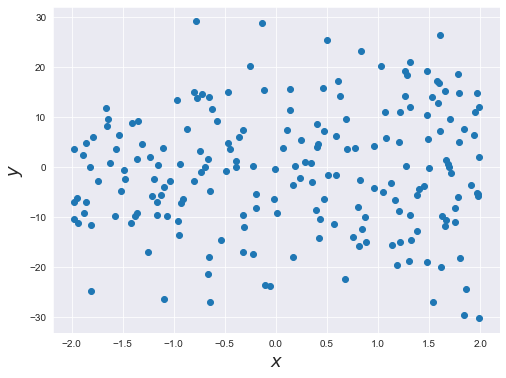

In [4]:
plt.figure(figsize=(8,6))

plt.scatter(x,y)

plt.xlabel("$x$",fontsize=18)
plt.ylabel("$y$",fontsize=18)

plt.show()

##### 1. Fit the typical linear regression model for the model you are interested in,
##### 2. Calculate the residuals for that model

In [5]:
## fit the regression here
ols = LinearRegression(copy_X=True)
ols.fit(x.reshape(-1,1), y)

## calculate residuals
residuals = y - ols.predict(x.reshape(-1,1))

## calculate the absolute residuals
abs_resid = np.abs(residuals)



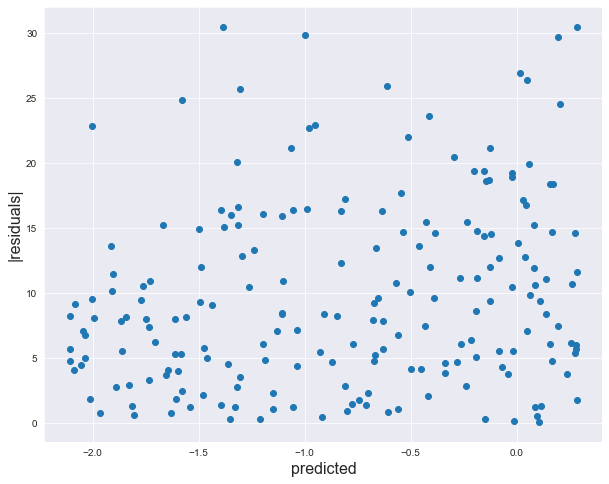

In [6]:
## plot abs(residuals) agains predicted
plt.figure(figsize=(10,8))

plt.scatter(ols.predict(x.reshape(-1,1)), abs_resid)

plt.xlabel("predicted", fontsize=16)
plt.ylabel("|residuals|", fontsize=16)

plt.show()

##### 3. Regress the absolute value of the residuals for that model on the predicted values, call this regression the w regression for reference

In [7]:
## fit the w regression
w_reg = LinearRegression(copy_X=True)
w_reg.fit(ols.predict(x.reshape(-1,1)).reshape(-1,1), abs_resid)

predicted = ols.predict(x.reshape(-1,1))

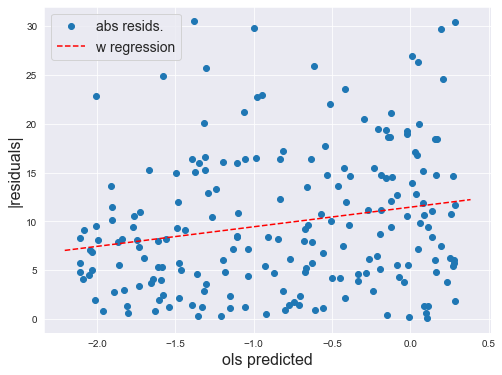

In [8]:
## plot abs(residuals) agains predicted

plt.figure(figsize=(8,6))

plt.scatter(predicted, 
               abs_resid,
               label="abs resids.")

plt.plot(np.linspace(np.min(predicted)-.1, np.max(predicted)+.1, 100),
            w_reg.predict(np.linspace(np.min(predicted)-.1, np.max(predicted)+.1, 100).reshape(-1,1)),
            'r--',
            linewidth=1.5,
            label="w regression")

plt.legend(fontsize=14)
plt.xlabel("ols predicted", fontsize=16)
plt.ylabel("|residuals|", fontsize=16)

plt.show()

##### 4. Use the w regression model to get the $\sigma_i$s,

In [9]:
## get the sigma_is
sigma_is = w_reg.predict(predicted.reshape(-1,1))


## get the w_is
w_is = 1/np.power(sigma_is, 2)

##### 5. Fit your weighted linear regression model.

In [10]:
## Fit the model
wls = LinearRegression(copy_X=True)

wls.fit(x.reshape(-1,1), y, sample_weight=w_is)

LinearRegression()

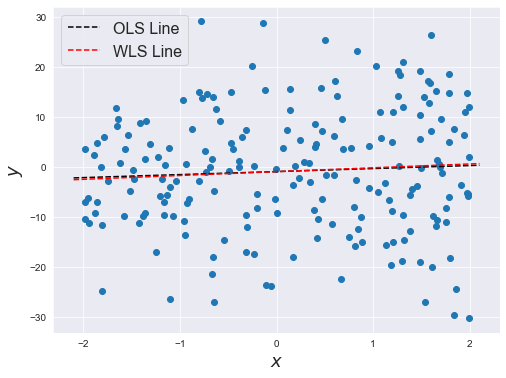

In [11]:
## plot the results
## compare ols to wls
plt.figure(figsize=(8,6))

plt.scatter(x,y)
plt.plot(np.linspace(-2.1,2.1,100),
            ols.predict(np.linspace(-2.1,2.1,100).reshape(-1,1)),
            'k--',
            label="OLS Line")
plt.plot(np.linspace(-2.1,2.1,100),
            wls.predict(np.linspace(-2.1,2.1,100).reshape(-1,1)),
            'r--',
            label="WLS Line")

plt.legend(fontsize=16)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("$y$",fontsize=18)

plt.show()

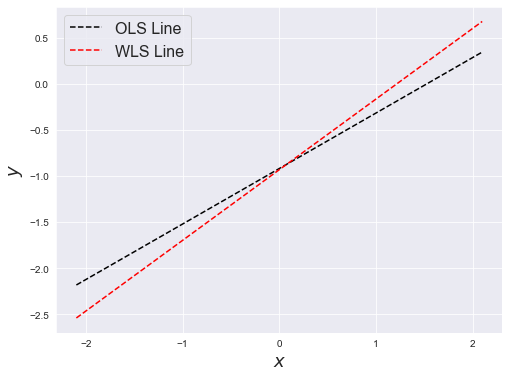

In [12]:
## plot the results
## compare ols to wls
plt.figure(figsize=(8,6))

plt.plot(np.linspace(-2.1,2.1,100),
            ols.predict(np.linspace(-2.1,2.1,100).reshape(-1,1)),
            'k--',
            label="OLS Line")
plt.plot(np.linspace(-2.1,2.1,100),
            wls.predict(np.linspace(-2.1,2.1,100).reshape(-1,1)),
            'r--',
            label="WLS Line")

plt.legend(fontsize=16)
plt.xlabel("$x$",fontsize=18)
plt.ylabel("$y$",fontsize=18)

plt.show()

--------------------------

This repository was written for the 2021 Erdős Institute Fall Data Science Semester by Matthew Osborne, Ph. D., 2021.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute. (see License.md)